# Formas de pagamento mais populares nas plataformas geridas pela Olist

Este estudo visa entender os padrões de pagamento de clientes em plataformas de e-commerce. Bem como tentar prever pelo valor da compra se será feito no crédito, boleto, etc...
O dataset usado é o [Brazilian E-Commerce Public Dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) disponibilizado pela Olist na plataforma Kaggle. O Dataset contém informações sobre compras realizadas de 2016 a 2018, incluindo dados dos clientes, compradores, geográficos, formas de pagamento e os itens que foram comprados.


# Schema do Banco de Dados
<img src="images/schema.png" alt="schema" width="1000"/>

## As tabelas revelantes para a pesquisa são:

### 1. Pagamentos, em cinza
### 2. Pedidos, em vermelho
### 3. E Clientes em azul claro

#### Também serão exploradas as relações entre os métodos de pagamentos usados por clientes que moram em capitais versus o resto do Brazil.

In [134]:
import pandas as pd 

pagamentos = pd.read_csv("olist_order_payments_dataset.csv")

pagamentos.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95


In [135]:
pagamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [136]:
pagamentos.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


Como o número de não-nulos bate com o número de linhas totais do dataset, concluímos que pouca ou nenhuma limpeza dos dados será necessária.
Pelo método describe também obtemos duas estatísticas interessantes: O valor médio de uma compra do brasileiro é de 154 reais. O número médio de parcelas numa compra no crédito é próximo de 3. Levando em consideração o desvio padrão de 217 reais para o valor da compra, estima-se que compras acima de 1000 reais são bem raras. Vamos tirar sua porcentagem:

In [137]:
pagamentos[pagamentos["payment_value"] >= 1000].shape[0]/pagamentos.shape[0]


0.011069826540631076

### Compras acima de 1000 reais representam apenas 1,106% dos dados.

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

fig, ax = plt.subplots(figsize=(8,8))
grafico = sns.histplot(ax=ax, data=pagamentos, x="payment_value", bins=500)
grafico.set_xlim(0,1000)
grafico.set_xlabel("Valor do pagamento")
grafico.set_ylabel("Contagem")


Text(0, 0.5, 'Contagem')

### Podemos ver claramente as tendências, a maioria das compras se concentra na faixa de 0 a 200 reais, com valores mais altos tendo uma frequência decrescente. Como se tratam de pagamentos, tratar os valores muito altos como outliers e retirá-los do estudo não é interessante.

In [139]:
(pagamentos["payment_type"].value_counts()/pagamentos.shape[0]).plot.bar()

<Axes: xlabel='payment_type', ylabel='Contagem'>

## Temos que aproximadamente:
#### 1. 74% das compras são via cartão de crédito
#### 2. 19% via boleto
#### 3. 5.5% via voucher
#### 4. 1.4% via débito

## Temos 3 linhas com um método de pagamento não especificado: vamos retirá-las para construção dos modelos de machine learning.

In [140]:
pagamentos_filtrado = pagamentos.loc[pagamentos['payment_type'] != 'not_defined']
pagamentos_filtrado["payment_type"].value_counts()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
Name: count, dtype: int64

In [141]:
pagamentos_filtrado.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Precisamos retirar colunas que não agregam valor as predições: order_id que é apenas um identificador dos pedidos e payment_installments que se refere ao número de parcelas da compra. Payment_installments automaticamente introduziria overfitting no modelo por ser um atributo específico de pagamentos realizados no crédito quando o valor é maior que 1. Pagamento sequencial também não afeta já que é possível mesclar todas as 4 formas de pagamento. Neste momento inicial ficariamos apenas com o tipo da compra e o valor. Um número limitado de features que deverá produzir modelos com acurácia baixa. Portanto, traremos informações sobre o local da compra para agregar valor as predições.

In [142]:
usuarios = pd.read_csv("olist_customers_dataset.csv")
pedidos = pd.read_csv("olist_orders_dataset.csv")

pagamentos_cep = pagamentos_filtrado.merge(pedidos, on="order_id").merge(usuarios, on="customer_id")
pagamentos_cep.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP


In [143]:
pagamentos_cep.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')

Vamos novamente selecionar apenas colunas que parecem que ter efeitos na predição. Removeremos os Id's e as colunas de tempo.

In [144]:
features = ['payment_value']
target = "payment_type"

# Optamos por retirar as cidades nesse primeiro teste já que existem muitas cidades com nomes repetidos em diferentes estados.

## Seleções:
### 1. Valor do pagamento
### 2. CEP
### 3. Estado

## Começamos o processo de machine learning separando e fazendo o encoding das features. Também separamos 20% do dataset para teste. Transformaremos a sigla de cada estado em um valor.

In [145]:
from sklearn.model_selection import train_test_split


estados = pagamentos_cep["customer_state"].str.get_dummies()

estados_nomes = estados.columns

encoded_pagamentos = pagamentos_cep.join(estados)

for coluna in estados_nomes:
    features.append(coluna)

X = encoded_pagamentos[features]
y = pagamentos_filtrado[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=64)


## Utilizaremos 3 modelos com níveis crescentes de complexidade, Logistic Regressor, SVM classifier e Random Forest classifier. Em especial o modelo Random Forest é do tipo Emsemble, que tenta aumentar a acurácia das previsões criando modelos mais específicos com sistema de votação. Começamos com o modelo mais básico de regressão lógica.

In [146]:
from sklearn.linear_model import LogisticRegression

LogRegModel = LogisticRegression(random_state=64)
LogRegModel.fit(X_train, y_train);
resultado_LogReg = pd.DataFrame(LogRegModel.predict(X_test))

In [147]:
resultado_LogReg.value_counts()

credit_card    20777
Name: count, dtype: int64

In [148]:
y_test.value_counts()

payment_type
credit_card    15339
boleto          3948
voucher         1168
debit_card       322
Name: count, dtype: int64

### Como esperado resultou num modelo que prevê que todas as compras são no cartão de crédito. Não é nem necessário entrar em detalhes com a matriz de confusão e afins. Partimos para o SVM, que tenta criar zonas e barreiras no dataset para capturar padrões.

In [149]:
from sklearn import svm

SVMRegModel = svm.SVC(max_iter=200,random_state=64);
SVMRegModel.fit(X_train,y_train);
resultado_SVMReg = pd.DataFrame(SVMRegModel.predict(X_test));


C:\Users\Outback_Steakhouse\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [150]:
resultado_SVMReg.value_counts()

voucher        16229
debit_card      2243
boleto          2028
credit_card      277
Name: count, dtype: int64

### Mesmo após várias tentativas o SMV insiste em classificar a maioria dos elementos como Voucher, algo na distribuição dos valores inviabiliza o algorítmo. Partiremos então para o último e mais robusto modelo: Random Forest.


In [151]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=64)
RFC.fit(X_train,y_train);
resultadoRFC = RFC.predict(X_test)


In [152]:
resultRFC = pd.DataFrame(resultadoRFC)

In [153]:
resultRFC.value_counts()

credit_card    17153
boleto          2689
voucher          753
debit_card       182
Name: count, dtype: int64

### Só pela distribuição dos valores percebemos uma melhora. Prosseguiremos apenas com Random Forest daqui para frente. Vamos analisar a matriz de confusão.

In [170]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style("whitegrid",{"grid.linestyle": ""})

CM = confusion_matrix(y_test,resultRFC,labels=RFC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=RFC.classes_)
disp.plot(cmap='magma')

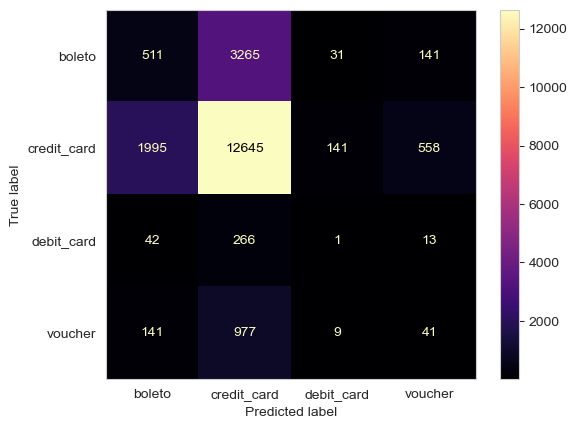

In [171]:
plt.show()

### Percebemos que o modelo acerta na estimativa do cartão de crédito aproximadamente 90% das vezes. Mas erra todas as outras classes em mais de 90% sendo necessário refinar o modelo. Vamos tentar adicionar uma feature.

### Utilizando os dados geográficos disponíveis nas tabelas iniciais vamos adicionar a coluna "capital" que simboliza se o comprador mora numa cidade que é a capital do estado ou não. A motivação seria que pessoas na capital em geral possuem maior poder aquisitivo então os hábitos de compra também devem tem alguma mudança.

In [180]:
def capital_selector(estado, cidade):
    sigla_cidade={'AC': "rio branco", 
          'AL': "maceio", 
          'AM': "manaus", 
          'AP': "macapa", 
          'BA': "salvador", 
          'CE': "fortaleza", 
          'DF': "brasilia", 
          'ES': "vitoria", 
          'GO': "goiania", 
          'MA': "sao luis", 
          'MG': "belo horizonte", 
          'MS': "porto alegre",
          'MT': "cuiaba",
          'PA': "belem",
          'PB': "joao pessoa",
          'PE': "recife",
          'PI': "teresina",
          'PR': "curitba",
          'RJ': "rio de janeiro",
          'RN': "natal",
          'RO': "porto velho",
          'RR': "boa vista",
          'RS': "porto alegre",
          'SC': "florianopolis",
          'SE': "aracaju",
          'SP': "sao paulo",
          'TO': "palmas"
          }
    if sigla_cidade[estado] == cidade:
        return 1
    else:
        return 0

In [193]:
eh_capital = [capital_selector(linha.customer_state,linha.customer_city) for index, linha in pagamentos_cep.iterrows()]
capital_serie = pd.Series(eh_capital)
capital_serie.rename("Capital",inplace=True)

0         0
1         1
2         1
3         0
4         0
         ..
103878    0
103879    1
103880    1
103881    1
103882    1
Name: Capital, Length: 103883, dtype: int64

## Repreparando as features:

In [194]:
X_capital = X.join(capital_serie)
X_capital.head()

,payment_value,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,RJ,RN,RO,RR,RS,SC,SE,SP,TO,Capital
0,99.33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24.39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,65.71,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,107.78,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,128.45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [195]:
X_trainC, X_testC, y_trainC, y_testC = train_test_split(X_capital,y,test_size=0.2,random_state=64)

In [197]:
RFC_capital = RandomForestClassifier(random_state=64)
RFC_capital.fit(X_trainC,y_trainC);
resultadoRFC_capital = RFC_capital.predict(X_testC)

In [199]:
resultRFC_capital = pd.DataFrame(resultadoRFC_capital)

In [201]:
resultRFC_capital.value_counts()

credit_card    16779
boleto          2996
voucher          785
debit_card       217
Name: count, dtype: int64

In [203]:
CM_capital = confusion_matrix(y_testC,resultRFC_capital,labels=RFC_capital.classes_)
disp_capital = ConfusionMatrixDisplay(confusion_matrix=CM_capital, display_labels=RFC_capital.classes_)
disp_capital.plot(cmap='magma')

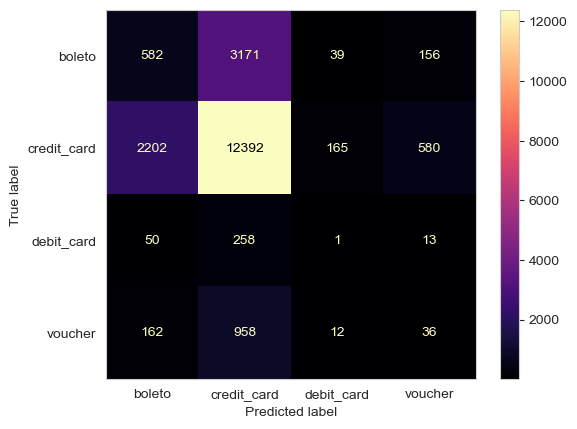

In [204]:
plt.show()

### A matriz de confusão é quase identica a primeira tentativa. Adicionar a coluna capital não parece ter surtido muito efeito. Vamos tentar então validação cruzada com vários parâmetros. Utilizaremos acurácia balanceada como medida de erro.

In [207]:
from sklearn.model_selection import GridSearchCV
FinalRandomForest = RandomForestClassifier(random_state=64)
parametros = {'n_estimators':[1, 5, 10, 50, 100, 200],
              'bootstrap':[True,False]
              }
grid = GridSearchCV(estimator = FinalRandomForest,
                      param_grid = parametros,
                      cv = 5,
                      scoring = 'balanced_accuracy')

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=64),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [1, 5, 10, 50, 100, 200]},
             scoring='balanced_accuracy')

In [213]:

grid.best_params_
#gridresults = pd.DataFrame(grid.cv_results_)

{'bootstrap': True, 'n_estimators': 10}

## A melhor predição ocorreu utilizando bootstrap e apenas 10 estimadores. Vamos refazer o modelo:

In [214]:
RFC_best = RandomForestClassifier(random_state=64,bootstrap=True,n_estimators=10)

In [215]:
RFC_best.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=64)

In [216]:
result_best = RFC_best.predict(X_test)

In [218]:
RFC_pred_final = pd.DataFrame(result_best)

In [219]:
RFC_pred_final.value_counts()

credit_card    16958
boleto          2915
voucher          732
debit_card       172
Name: count, dtype: int64

## Vamos olhar as métricas finais de score

In [221]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

CM_best = confusion_matrix(y_test,RFC_pred_final,labels=RFC_best.classes_)
disp_best = ConfusionMatrixDisplay(confusion_matrix=CM_best, display_labels=RFC_best.classes_)
disp_best.plot(cmap='magma')

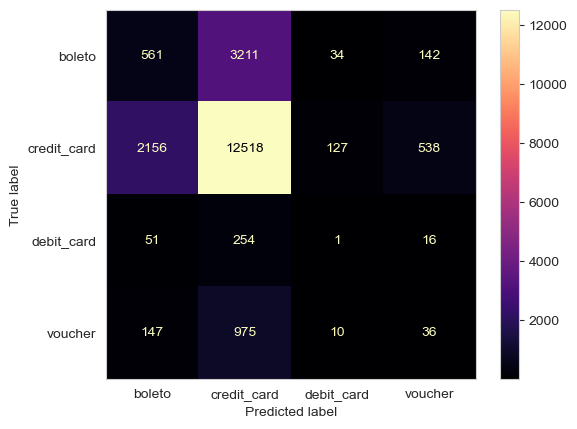

In [222]:
plt.show()

In [224]:
precision_score(y_test,RFC_pred_final,average="weighted")

0.5843967106873696

In [229]:
precision_score(y_test,RFC_pred_final,average="macro")


0.24640594583080905

In [225]:
accuracy_score(y_test,RFC_pred_final)

0.6312749675121528

In [232]:
recall_score(y_test,RFC_pred_final,average="macro")

0.24802861957156158

### As notas são relativamente boas, mas não significam muito se levarmos em conta que na prática o modelo só acerta predições quando o meio utilizado foi cartão de crédito. O experimento se mostrou insuficiente devido a pouca quantidade de features possíveis de serem utilizadas no dataset original. Outra possível forma de interpretação é que não existe forte correlação entre o valor da compra e o meio de pagamento utilizado.